# Baseline analysis for Lenet Linear model

In [1]:
import sys
sys.path.append('../src/')
import os
import copy

import numpy as np
import sklearn
from sklearn import metrics
import tensorly as tn
import math
import matlab.engine
import matplotlib.pyplot as plt
import time


import ll1_tools

## Load data and loewnerize

In [2]:
targets_path = '../data/LenetLinear/activations/test/targets.npy'
targets = np.load(targets_path)
print(f"Targets shape: {targets.shape}")

# inputs_path = '../data/LenetLinear/activations/test/99/layers.layer_0.linear.npy'
inputs_path = '../data/LenetLinear/activations/test/99/layers.layer_0.npy'
inputs_raw = np.load(inputs_path)
print(f"Inputs shape: {inputs_raw.shape}")

outputs_path = '../data/LenetLinear/activations/test/99/layers.layer_0.rat.npy'
outputs_raw = np.load(outputs_path)
print(f"Outputs shape: {outputs_raw.shape}")

# tensorlab_path = '~/ware/matlab_tools/tensorlab'
tensorlab_path = '~/tools/matlab_tools/Tensorlab'

num_sets = 10

lwn_tns, obs, obs_trgts = ll1_tools.split_data(inputs_raw, outputs_raw, targets, tensorlab_path, num_sets)

Targets shape: (9984,)
Inputs shape: (39, 256, 10)
Outputs shape: (39, 256, 10)


## perform decompositions for all lwn_tns

In [3]:
eng = matlab.engine.start_matlab()
s = eng.genpath(tensorlab_path)
eng.addpath(s, nargout=0)

num_terms = 25
rat_deg = 3

L = rat_deg * np.ones(num_terms)
mdls = list()
outs = list()

tic = time.perf_counter()
for tns in lwn_tns:
    U, out = eng.ll1(tns, L, nargout=2)
    mdls.append(U)
    outs.append(out)
toc = time.perf_counter()
print(toc-tic)
# eng.quit()

> In ll1_core/state (line 238)
In ll1_core (line 191)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll

## check model fits

In [4]:
fits = []
for idx, mdl in enumerate(mdls):
    tmp_fit = 1 - eng.frobll1res(lwn_tns[idx], mdl) / eng.frob(lwn_tns[idx])
    fits.append(tmp_fit)
print(fits)

[0.9997689775490625, 0.9996691264978987, 0.999872378265069, 0.9998678997984008, 0.9998376369017383, 0.9997896407486699, 1.0, 0.9998623828788112, 0.9998477281363995, 0.999949639036759]


## Recover 'Sources' & 'Mixing' matrices for each set

In [41]:
print(f"Number of models: {len(mdls)}")
sources = list()
mixes = list()
for idx, model in enumerate(mdls):
    tmp = ll1_tools.pack_ll1(model)
    mix = tmp[2]
    mixes.append(mix)
    src = ll1_tools.recover_sources(obs[idx], mix)
    sources.append(src)
print(f"Number of Source matrices: {len(sources)}")
print(f"Number of Mixing matrices: {len(mixes)}")

Number of models: 10
Number of Source matrices: 10
Number of Mixing matrices: 10


## Perform SVDs on transposed 'Sources' matrices as well as maximum angle between subspaces
(transpose so the left singular vectors correspond to the sources signal space)

In [42]:
# eng = matlab.engine.start_matlab()
# s = eng.genpath(tensorlab_path)
# eng.addpath(s, nargout=0)

sources_transposed = []
for src in sources:
    sources_transposed.append(src.T)
print(len(sources_transposed))

svds = []
for src in sources_transposed:
    svds.append(np.linalg.svd(src))
num_sets = len(sources)

angles_srcs = np.zeros((num_sets,num_sets))
angles_cols = np.zeros((num_sets,num_sets))
norm_of_diffs = np.zeros((num_sets,num_sets))
# cossims = np.zeros((num_sets,num_sets))
for i in range(num_sets):
    for j in range(num_sets):
        if i != j:
            angles_srcs[i,j] = eng.rad2deg(eng.subspace(sources_transposed[i], sources_transposed[j]))
            angles_cols[i,j] = eng.rad2deg(eng.subspace(svds[i][0], svds[j][0]))
            norm_of_diffs[i,j] = np.linalg.norm(sources_transposed[i] - sources_transposed[j])
            # cossims[i,j] = sklearn.metrics.pairwise.cosine_similarity(sources_transposed[i], sources_transposed[j])

10


## SVD analysis

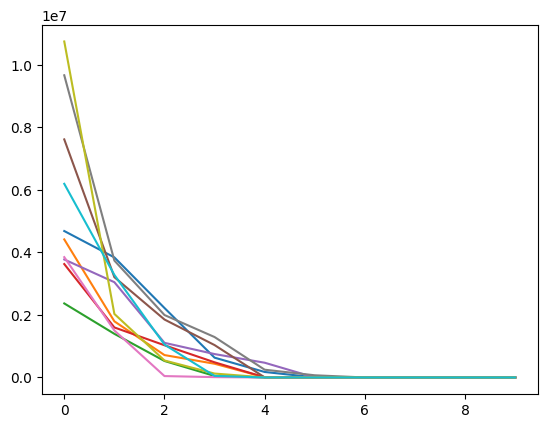

In [43]:
for i in range(len(svds)):
    plt.plot(svds[i][1])

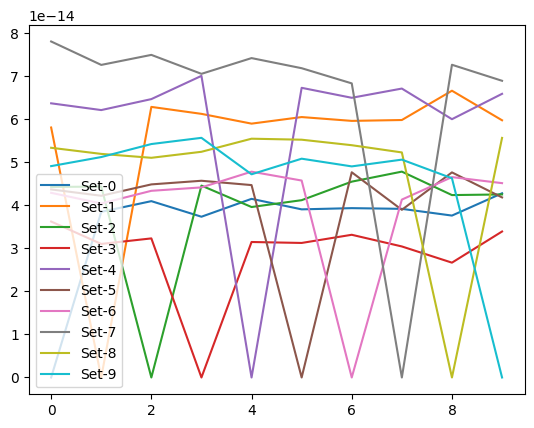

In [44]:
for i in range(angles_cols.shape[0]):
    plt.plot(angles_cols[i,:], label=f"Set-{i}")
plt.legend()

## Norm of diff analysis

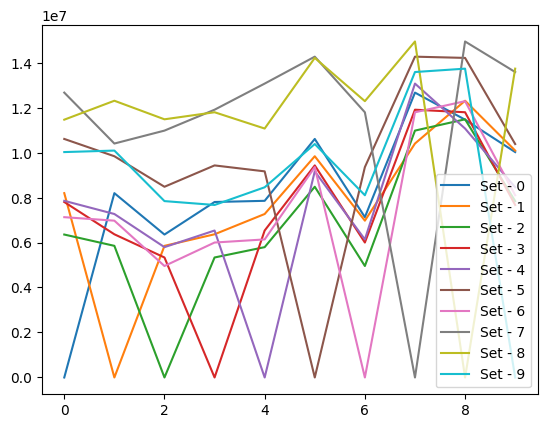

In [45]:
# basic visualization
for i in range(norm_of_diffs.shape[0]):
    plt.plot(norm_of_diffs[i,:], label=f"Set - {i}")

plt.legend()

10
(10, 10)


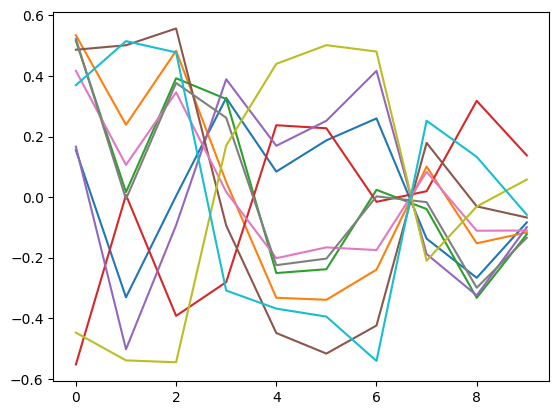

In [46]:
print(len(sources_transposed))
tmp = metrics.pairwise.cosine_similarity(sources_transposed[0], sources_transposed[1])
print(tmp.shape)
plt.plot(tmp)
# for i in range(len(sources_transposed)):
#     plt.plot(